## Custom Marker (Optional)
The following packages allow you to create a custom marker for matplotlib from any svg file. <br> 
This way we can actually display the agent as a little robot. A complete tutorial on that can be found [here](https://petercbsmith.github.io/marker-tutorial.html).

## Imports 

In [2]:
# Imports for custom marker
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

In [3]:
import numpy as np # ndarrays as representation of the gridworld
from typing import Tuple # For type hinting 
import copy # For making deep copies

# For plotting
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import colors 
from matplotlib.patches import Patch

In [4]:
# Load the image
path, attributes = svg2paths('Robot.svg')

In [5]:
# Extract the outlines
marker = parse_path(attributes[2]['d'])

# Minor changes such that the marker is displayed correctly 
marker.vertices -= marker.vertices.mean(axis=0)
marker = marker.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))
marker = marker.transformed(matplotlib.transforms.Affine2D().scale(-1,1))

# **Task 01:**

Implement your own Gridworld

## Gridworld Class
The default values for `obstacles`, `portals`, `negative_rewards` and `terminal_state` are designed for a 7x7 girdworld. <br>
Feel free to adjust the values to your liking or even add new [y,x] coordinate pairs.

In [6]:
class Gridworld():
    """Implements the Gridworld class
    
    Legend:
    
    0 = Empty field

    1 = Obstacle

    2 = Terminal State

    3 = Negative Reward

    4 = Portals
    """

    # Initialize the class variables
    
    # Agent position in the environment
    agent_x_pos = None
    agent_y_pos = None
    
    # Positions of all obstacles, portals and negative rewards
    obstacles = [[1,1], [1,4], [2,1], [2,2], [2,3], [2,4], [2,5], [3,2], [4,2], [5,2], [5,4], [5,5], [5,6]]
    portals = [[3,5], [4,1], [6,5]]
    negative_rewards = [[1,2], [1,3], [3,1], [6,4], [6,6]]
    terminal_state = [3,3]
    
    # Colors for the different properties a field in the environment can have
    plot_colors = ['white', 'black', 'green', 'red', 'orange']

    
    
    def __init__(self, size: Tuple[int,int]): 
        """Initialize agent at start position and nd.array containing gridworld with all obstacles, rewards and portals.
        
        Arguments:
            size(tuple): Size of the gridworld
        """
        
        # gridworld[:,:,0] describes the world
        # gridworld[:,:,1] describes the rewards
        self.gridworld = np.zeros((size[0], size[1], 2))
        self.world_size = size

        # Initializes the agent in the upper left corner
        self.agent_x_pos = 0
        self.agent_y_pos = 0
        
        # Assigns a low negative reward for every step
        self.gridworld[:, :, 1] = -0.1
        

        # Set the terminal state and add a positive reward
        self.gridworld[self.terminal_state[0], self.terminal_state[1], 0] = 2
        self.gridworld[self.terminal_state[0], self.terminal_state[1], 1] = 10

        # Set the obstacles
        for obst in self.obstacles:
            self.gridworld[obst[0], obst[1], 0] = 1

        # Set the portals
        for port in self.portals:
            self.gridworld[port[0], port[1], 0] = 4

        # Assign negative rewards to states
        for rew in self.negative_rewards:
            self.gridworld[rew[0], rew[1], 0] = 3
            self.gridworld[rew[0], rew[1], 1] = -1
        
        # Initialize Q-values as 0
        self.Q = { "up": np.zeros((size[0], size[1])), "down" : np.zeros((size[0], size[1])), "right" : np.zeros((size[0], size[1])), "left" : np.zeros((size[0], size[1]))}
        
        # To store past states, actions and rewards
        self.past_n_steps = [] 

        
        
    def visualize(self, redraw: bool=False, action: str='', episode: int=0, epsilon: float=0.0):
        """Prints the current state of the world
        
        Arguments:
            redraw (bool): Determines whether to plot dynamically or not
            action (str): Current action of the agent
            episode (int): Current episode of a run 
            epsilon (float): Current epsilon during a run
        """
        
        # Creates the figure and legend color patches
        if not redraw:
            self.fig, self.ax = plt.subplots(figsize=(9, 6))

            self.legend_elements = [Patch(facecolor=self.plot_colors[0], edgecolor='gray', label='Empty Field'),
                           Patch(facecolor=self.plot_colors[1], edgecolor='gray', label='Obstacle'),
                           Patch(facecolor=self.plot_colors[2], edgecolor='gray', label='Terminal State'),
                           Patch(facecolor=self.plot_colors[3], edgecolor='gray', label='Negative Reward'),
                           Patch(facecolor=self.plot_colors[4], edgecolor='gray', label='Portal')]
       
        # Enables interactive mode and clears the axis for redrawing
        else:
            plt.ion()
            self.ax.clear()
        
        
        # Setup the axes ticks
        plt.setp(self.ax, xticks=np.arange(0.5, self.world_size[1], step=1), xticklabels=[i for i in range(self.world_size[1])], yticks=np.arange(0.5, self.world_size[0], step=1), yticklabels=[i for i in range(self.world_size[0])])
        
        # Plot all obstacles, rewards and portals in their respective color 
        # as well as the agent at his current position
        self.ax.pcolor(self.gridworld[:,:,0], cmap=colors.ListedColormap(self.plot_colors), edgecolors='k')
        self.ax.plot(self.agent_x_pos+0.5, self.agent_y_pos+0.5, marker=marker, markersize=40)
    
        
        # Create deepcopy of Q-vlaues for rescaling 
        tmp = copy.deepcopy(self.Q)
        
        # Zip each action for a respective state together
        tmp = [list(zip(tmp['up'][row], tmp['down'][row], tmp['right'][row], tmp['left'][row])) for row in range(self.world_size[1])]

        # Draw the q-values as arrows inside each field, indicating the current policy 
        for x in range(self.world_size[0]):
            for y in range(self.world_size[1]):
                
                q_values = np.array(tmp[y][x])
                max_q = max(q_values)
                min_q = min(q_values)
                
                # Normalize between 0 and 1
                if max_q != min_q:
                    q_values -= min_q
                    q_values /= (max_q-min_q)
                    q_values *= 0.3
                
                q_values += np.finfo(float).eps # to let all arrows point in the right direction
                
                # up
                plt.arrow(x+0.5, y+0.5, 0, q_values[0], head_width=0.05, head_length=0.1, fc='k', ec='k')
                # down
                plt.arrow(x+0.5, y+0.5, 0, -q_values[1], head_width=0.05, head_length=0.1, fc='k', ec='k')
                # right
                plt.arrow(x+0.5, y+0.5, q_values[2], 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
                # left
                plt.arrow(x+0.5, y+0.5, -q_values[3], 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
        
        
        # Draw the legend next to the plot and adjust the size of the canvas
        plt.legend(handles=self.legend_elements, bbox_to_anchor=(1.04,0.5), borderaxespad=0, loc="center left")
        plt.subplots_adjust(right=0.7)
        
        
        if not redraw:    
            plt.show()
        else:
            self.ax.title.set_text(f'Action: {action} | Current Episode: {episode} | Current Epsilon: {np.round(epsilon, 2)}')
            self.fig.canvas.draw() 


            
    def reset(self):
        """Resets q-values and list of past n steps, as well as places agent at (0,0)"""
        
        # Set all q-values to 0
        self.Q = { "up": np.zeros((self.world_size[0], self.world_size[1])), "down" : np.zeros((self.world_size[0], self.world_size[1])), "right" : np.zeros((self.world_size[0], self.world_size[1])), "left" : np.zeros((self.world_size[0], self.world_size[1]))}
        
        # Reset the list of past steps
        self.past_n_steps = [] 
        
        # Place the agent at the start state
        self.agent_x_pos = 0
        self.agent_y_pos = 0


        
    def step(self, action: str):
        """Function that checks whether the action chosen by the agent is actually legal or not. If the action is legal 
        it repositions the agent according to the action he chose. If the action is illegal, then the agent remains in 
        his current state
        
        Arguments:
            action(str): Action performed by the agent
        
        Returns:
            reward (float): Reward the agent receives (r_t|S_t,A_t)
        """

        # Copy the agents current position
        new_x = self.agent_x_pos
        new_y = self.agent_y_pos
        reward = -0.01

        # obtain new (x,y) coordinates
        if action == "up":
            new_y += 1

        elif action == "down":
            new_y -= 1

        elif action == "left":
            new_x -= 1

        elif action == "right":
            new_x += 1
        
        else:
            raise Exception("Action must be either 'up', 'down', 'left', 'right'")

        # Check if x or y are out of bounds and whether the new position is blocked by an obstacle
        if (new_x < 0 or new_x >= len(self.gridworld[:,:,0][0])) or (new_y < 0 or new_y >= len(self.gridworld[:,:,0])) or (self.gridworld[new_y,new_x,0]==1):
            return reward

        # Check if new postion is a a portal and randomly chose to which other portal the agent is teleported
        elif self.gridworld[new_y,new_x,0]==4:
            
            # Create a deep copy
            remaining_portals = copy.deepcopy(self.portals)
            
            # Pop the current pos of the agent from the portal list such that we only sample from the remaining ones
            for idx, portal in enumerate(self.portals):
                if portal == [new_y, new_x]:
                    remaining_portals.pop(idx)
            
            # Sample portal and retreive reward
            self.agent_y_pos, self.agent_x_pos = remaining_portals[np.random.randint(0,2)]
            reward = self.gridworld[self.agent_y_pos, self.agent_x_pos, 1]
            
            return reward
            
        # If new position isn't blocked nor a portal, reposition agent to the new position
        else:
            # Set agent to the new position and retrieve the reward
            self.agent_y_pos = new_y
            self.agent_x_pos = new_x
            reward = self.gridworld[new_y,new_x,1] 

        return reward
    
    
    
    def policy(self, epsilon):
        """Choose an action for the current state the agent is in
        
        Arguments:
            epsilon (float): Hyperparameter for epsilon-greedy policy realising exploration/exploitation trade-off
        
        Returns:
            action (str): Either "up", "down", "right" or "left"
        """
        
        dic = { "up": self.Q["up"][self.agent_y_pos, self.agent_x_pos],
                "down": self.Q["down"][self.agent_y_pos, self.agent_x_pos],
                "right": self.Q["right"][self.agent_y_pos, self.agent_x_pos],
                "left": self.Q["left"][self.agent_y_pos, self.agent_x_pos] }

        # Retrieve the action with the highest q-value for the current position
        max_value = max(dic.values())
        max_keys = [k for k, v in dic.items() if v == max_value]
        # Tiebreak if multiple actions have the highest q-value
        action = np.random.choice(max_keys)
        
        # Epsilon greedy: with probability of epsilon take random action
        if np.random.uniform() < epsilon:
            action = np.random.choice(["up", "down", "right", "left"])
        
        return action
    
    
    
    def run(self, num_episodes: int, learning_rate: float, discount_factor: float, epsilon: float, SARSA_n: int):
        """Lets the agent perform a chosen amount of episodes. An episode ends when the agent reached a terminal state
        
        Arguments:
            num_episodes (int): Number of to be performed episodes
            learning_rate (float): Learning rate used to update the q-values
            discount_factor (float): Discount factor (gamma) weighting future rewards
            epsilon (float): Hyperparameter for epsilon-greedy policy realising exploration/exploitation trade-off
            SARSA_n (int): Sets the amount of steps for SARSA
        """

        # Variables to keep track of total reward and the current episode
        episode = 1
        init_epsilon = epsilon
        
        # Plot environment and agent using animated matplotlib plot
        self.visualize(redraw=False)
        
        # Initialize A_n_plus_one 
        A_n_plus_one = None
        
        
        # Loop until desired amount of episodes is performed
        while episode <= num_episodes:
            
            # Act according to epsilon-greedy policy and retrieve the reward
            S = [self.agent_x_pos, self.agent_y_pos]
            
            # Make sure that the action is taken that we used to update the q-value
            if A_n_plus_one != None:
                action = A_n_plus_one
            else:
                action = self.policy(epsilon)
                
            reward = self.step(action)

            # Store s,a,r triplet
            self.past_n_steps.append([S, action, reward])
            

            # If terminal state is reached, append n-1 further steps, such that the last n-1 steps of the epsiode get updates
            if self.gridworld[self.agent_y_pos, self.agent_x_pos, 0] == 2:
                for i in range(SARSA_n-1):
                    self.past_n_steps.append([[self.agent_x_pos, self.agent_y_pos], self.policy(epsilon), 0])
            
            
            # Update the Q-value
            while len(self.past_n_steps) >= SARSA_n:
                
                # Retrieve state S and action A (q-value to be updated)
                # the encountered rewards, as well as the n_th_plus_one state and action
                S = self.past_n_steps[0][0]
                A = self.past_n_steps[0][1]
                S_n_plus_one = [self.agent_x_pos, self.agent_y_pos]
                A_n_plus_one = self.policy(epsilon)
                rewards = [self.past_n_steps[i][2] for i in range(SARSA_n)]
                
                # Calculate the TD(n)-error
                TD_error = np.sum([ (discount_factor ** i) * rewards[i] for i in range(SARSA_n)]) + ((discount_factor ** SARSA_n) * self.Q[A_n_plus_one][S_n_plus_one[1],S_n_plus_one[0]]) - self.Q[A][S[1],S[0]]
                
                # Update q-values acc. to Q_new = Q_old + learning_rate * TD_error(n)
                self.Q[A][S[1],S[0]] += (learning_rate * TD_error)

                # Forget oldest step for the loop to work
                self.past_n_steps.pop(0)
                
                
            # Clear and redraw the agent position
            self.visualize(redraw=True, action=action, episode=episode, epsilon=epsilon)    
            
            
            # Check if terminal state has been reached
            if self.gridworld[self.agent_y_pos, self.agent_x_pos, 0] == 2:
                
                # Set the agent back to starting position at (0,0)
                self.agent_x_pos = 0
                self.agent_y_pos = 0
                
                # Reset the list of past steps
                self.past_n_steps = []
                
                # Gradually anneal epsilon towards 0 to gurantee convergence to an optimal policy
                epsilon -= (init_epsilon/num_episodes)
                
                # Increase the episode counter
                episode += 1

## Test the Gridworld

In [7]:
gridworld = Gridworld((7,7))

<IPython.core.display.Javascript object>


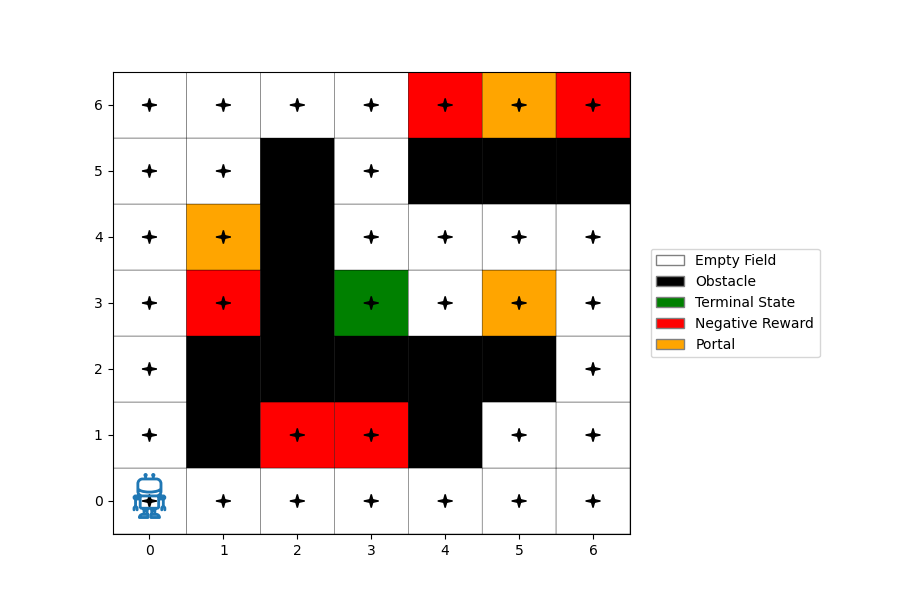

In [8]:
gridworld.visualize()

### Configure your own run by choosing
- the learning rate (alpha)
- the discount factor (gamma)
- epislon for exploration / exploitation trade-off
- amount of steps for SARSA

If you want to reset the gridworld, you can do so by simply calling `.reset()` on your gridworld object.

<IPython.core.display.Javascript object>


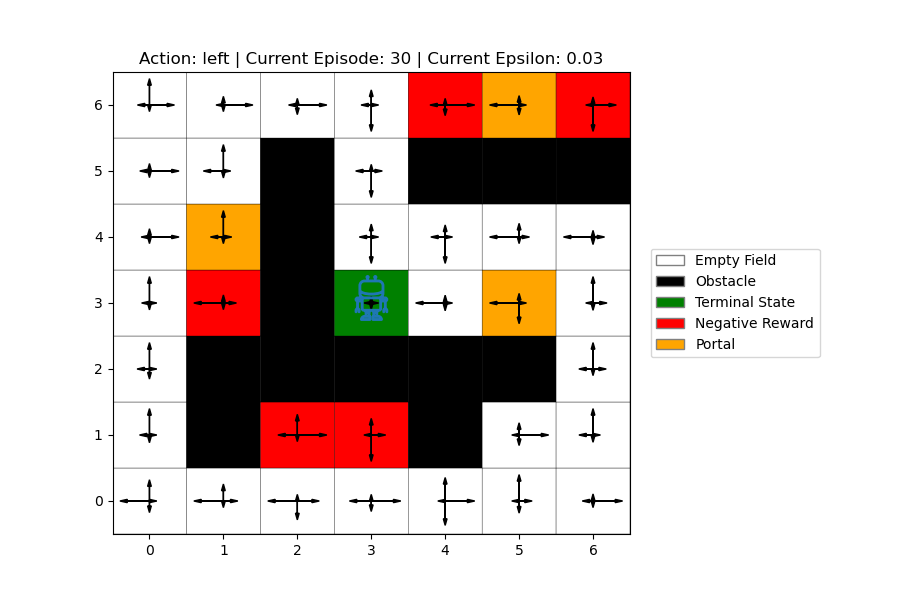

In [129]:
gridworld.run(num_episodes=30, learning_rate=0.1, discount_factor=0.9, epsilon=0.9, SARSA_n=20)

### Have a look at the respective q-value estimates

In [131]:
for line in reversed(np.round(gridworld.Q['up'],2)):
    print(line)

[ 2.69  0.58  0.42  2.54  0.09 -0.6   0.05]
[-0.02  1.81  0.    0.87  0.    0.    0.  ]
[-0.12  1.12  0.    3.62  1.45  1.31 -0.31]
[ 1.78 -0.43  0.    0.    0.73  1.03  1.81]
[1.39 0.   0.   0.   0.   0.   1.17]
[ 1.11  0.   -0.81 -0.79  0.   -0.24  0.82]
[ 0.95 -0.52 -1.25 -1.35 -0.54  0.2  -0.51]


In [132]:
for line in reversed(np.round(gridworld.Q['down'],2)):
    print(line)

[ 0.05  0.21  1.07  5.83  0.45 -0.54  0.28]
[-0.08  0.5   0.    7.44  0.    0.    0.  ]
[-0.37 -0.37  0.    8.15  4.59 -0.06 -0.16]
[-0.22 -0.5   0.    0.    0.72  3.43 -0.13]
[-0.51  0.    0.    0.    0.    0.    0.16]
[-0.34  0.   -0.97 -0.36  0.   -0.33 -0.41]
[ 0.02 -0.72 -0.77 -1.19 -0.52 -0.45 -0.55]


In [133]:
for line in reversed(np.round(gridworld.Q['right'],2)):
    print(line)

[ 2.15  3.75  4.72  0.07  1.87 -0.88  0.21]
[1.44 0.48 0.   1.97 0.   0.   0.  ]
[ 2.61 -0.3   0.    1.5   0.25  0.46  0.25]
[-0.25 -0.26  0.    0.    0.27  0.38  0.39]
[-0.91  0.    0.    0.    0.    0.    0.43]
[-0.43  0.   -0.75 -0.95  0.    0.47 -0.46]
[-0.45 -0.6  -0.75 -0.53 -0.48 -0.47  1.33]


In [134]:
for line in reversed(np.round(gridworld.Q['left'],2)):
    print(line)

[0.6  0.22 0.69 0.81 0.72 1.14 0.03]
[0.08 1.24 0.   3.31 0.   0.   0.  ]
[-0.24  0.01  0.    2.88  1.62  3.81  2.68]
[-0.21  0.44  0.    0.    7.71  4.66 -0.2 ]
[-0.39  0.    0.    0.    0.    0.    0.47]
[-0.25  0.   -0.85 -1.23  0.   -0.52 -0.07]
[ 1.44 -0.34 -0.48 -0.82 -0.84 -0.7  -0.27]
